In [222]:
import numpy as np
import pandas as pd
from scipy import stats
import re


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

In [223]:
plt.style.use('ggplot')

SEED = 42
np.random.seed(SEED)

TARGET = "Survived"
TRAIN_SET = "train.csv"
TEST_SET = 'test.csv'

In [224]:
df_train = pd.read_csv(TRAIN_SET)
df_test = pd.read_csv(TEST_SET)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

## First Intuition

In [225]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [226]:
numerical_variables = [var for var in df_train.columns if df_train[var].dtypes != 'O']
numerical_variables.pop(numerical_variables.index(TARGET))
numerical_variables_num = len(numerical_variables)
print('Number of numerical variables: ', numerical_variables_num)
for var in numerical_variables:
    print(var, end=' - ')

Number of numerical variables:  6
PassengerId - Pclass - Age - SibSp - Parch - Fare - 

In [227]:
discrete_vars = [var for var in numerical_variables if len(df_train[var].unique()) < 100]
discrete_vars_num = len(discrete_vars)
print('Number of discrete variables: ', discrete_vars_num)
for var in discrete_vars:
    print(var, end=' - ')

Number of discrete variables:  4
Pclass - Age - SibSp - Parch - 

In [228]:
continuous_vars = [var for var in numerical_variables if var not in discrete_vars+['PassengerId']]
print('Number of continuous variables: ', len(continuous_vars))
for var in continuous_vars:
    print(var, end=' - ')

Number of continuous variables:  1
Fare - 

In [229]:
categorical_variables = [var for var in df_train.columns if df_train[var].dtypes == 'O']
categorical_variables_num = len(categorical_variables)
print('Number of categorical variables: ', categorical_variables_num)
for var in categorical_variables:
    print(var, end=' - ')

Number of categorical variables:  5
Name - Sex - Ticket - Cabin - Embarked - 

In [230]:
print("Number of complete duplicates: ", df_train.duplicated().sum())

Number of complete duplicates:  0


In [231]:
print(f"Number of nulls in features: {df_train.isnull().sum().sum()}")

Number of nulls in features: 866


In [279]:
null_variables_in_numerics = [var for var in numerical_variables if df_train[var].isnull().sum() > 0]
print(f"Number of null features: {len(null_variables_in_numerics)}")
print(f"Number of nulls in numerical features: {df_train[null_variables_in_numerics].isnull().sum().sum()}")
num_nulls = df_train[numerical_variables].isnull().sum().sort_values(ascending=False)
for row in num_nulls.iteritems():
    print(f"{row[0]}    \t{row[1] }nulls \t{row[1]/df_train.shape[0]:.3f}%")

Number of null features: 1
Number of nulls in numerical features: 177
Age    	177nulls 	0.199%
Fare    	0nulls 	0.000%
Parch    	0nulls 	0.000%
SibSp    	0nulls 	0.000%
Pclass    	0nulls 	0.000%
PassengerId    	0nulls 	0.000%


In [280]:
null_variables_in_categoric = [var for var in categorical_variables if df_train[var].isnull().sum() > 0]
print(f"Number of null features: {len(null_variables_in_categoric)}")
print(f"Number of nulls in categorical features: {df_train[null_variables_in_categoric].isnull().sum().sum()}")
num_nulls = df_train[categorical_variables].isnull().sum().sort_values(ascending=False)
for row in num_nulls.iteritems():
    print(f"{row[0]}   \t{row[1]} nulls \t{row[1]/df_train.shape[0]:.3f}%")

Number of null features: 2
Number of nulls in categorical features: 689
Cabin   	687 nulls 	0.771%
Embarked   	2 nulls 	0.002%
Title   	0 nulls 	0.000%
Ticket   	0 nulls 	0.000%
Sex   	0 nulls 	0.000%


### First Intuition Summary
* 891 records. 
* 12 feature + target.
* 7 numerical feature include (id + target).
* 5 categorical features.
* 0 complete duplicates.
* 866 null value in all features.
* 177 nulls in numerical features.
* 689 nulls in categorical features.

## Target vs All

First we extract the meaningfull information from the 'Name'.

In [234]:
def get_title_from_name(passenger_name):
    line = passenger_name
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
df_train['Title'] = df_train['Name'].apply(get_title_from_name)
df_test['Title'] = df_test['Name'].apply(get_title_from_name)

categorical_variables.pop(categorical_variables.index('Name'));
categorical_variables += ['Title']

In [235]:
df_train[TARGET].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

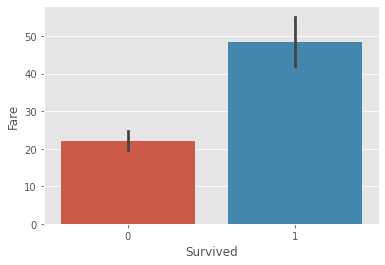

In [236]:
for var in continuous_vars:
    sns.barplot(data=df_train, y=var, x=TARGET)
    plt.show();

Who paid more has more chance to survive than he who doesn't. 

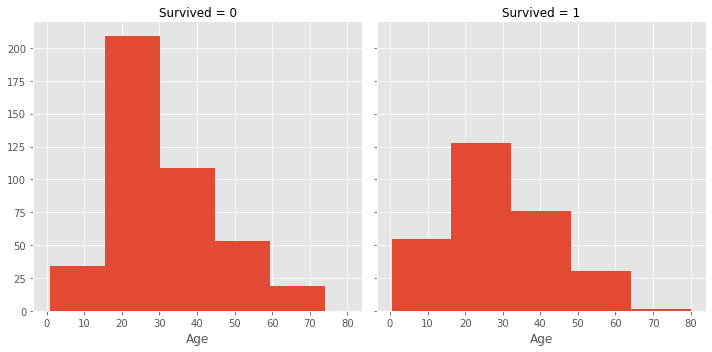

In [336]:
g = sns.FacetGrid(df_train, col=TARGET,height=5, aspect=1)
g.map(plt.hist, 'Age', bins=5);

In [312]:
df_train['AgeBand'] = pd.cut(df_train['Age'], 5)
tmp = df_train.groupby('AgeBand')['AgeBand'].count().sort_values(ascending=False)
pd.DataFrame(columns=['Count'], data=tmp.values, index=tmp.keys())

,Count
AgeBand,
"(16.336, 32.252]",346
"(32.252, 48.168]",188
"(0.34, 16.336]",100
"(48.168, 64.084]",69
"(64.084, 80.0]",11


In [265]:
df_train[['AgeBand', TARGET]].groupby('AgeBand').mean().sort_values(by=TARGET, ascending=False)

,Survived
AgeBand,
"(0.34, 16.336]",0.550000
"(48.168, 64.084]",0.434783
"(32.252, 48.168]",0.404255
"(16.336, 32.252]",0.369942
"(64.084, 80.0]",0.090909


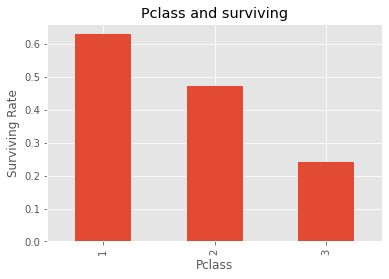

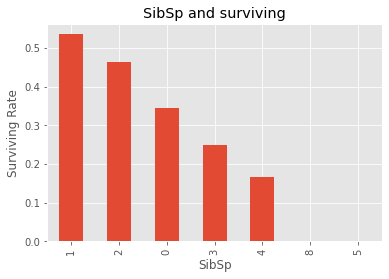

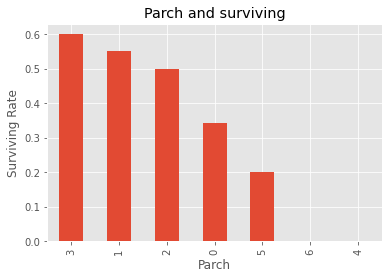

In [267]:
for i, var in enumerate(discrete_vars):
    if var == 'Age':
        continue
        
    df = df_train.groupby(var)[TARGET].mean().sort_values(ascending=False)
    df.plot.bar()
    plt.ylabel('Surviving Rate')
    plt.title(f'{var} and surviving')
    plt.show();

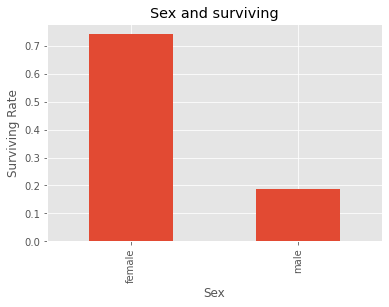

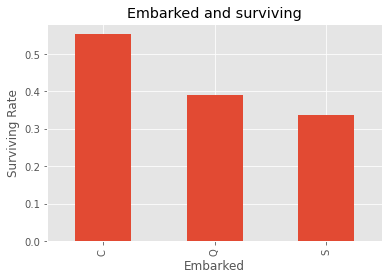

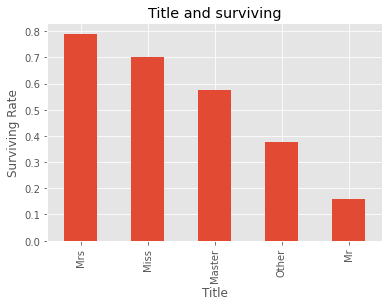

In [246]:
for i, var in enumerate(categorical_variables):
    if var in ['Name', 'Ticket', 'Cabin']:
        continue
        
    df = df_train.groupby(var)[TARGET].mean().sort_values(ascending=False)
    df.plot.bar()
    plt.ylabel('Surviving Rate')
    plt.title(f'{var} and surviving')
    plt.show();

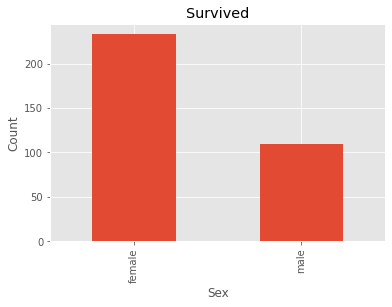

In [240]:
df_survived = df_train[df_train[TARGET] == 1]
df_survived.groupby('Sex')['Sex'].count().sort_values(ascending=False).plot.bar()
plt.ylabel('Count')
plt.title('Survived');

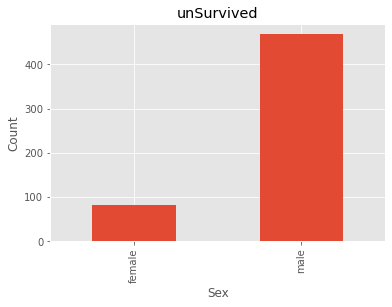

In [241]:
df_unsurvived = df_train[df_train[TARGET] == 0]
df_unsurvived.groupby('Sex')['Sex'].count().plot.bar();
plt.ylabel('Count')
plt.title('unSurvived');

## Summary

* Rich and upper class people survived more than medium or lower class people.
* Women survived more than men.
* Children and adult people survived more than the rest.

## Categoricals Association

In [339]:
cols = categorical_variables + ['Pclass'] + [TARGET]
n = len(cols)

**chi square test**

In [340]:
def get_chi_test(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix, correction=True)
    return chi2

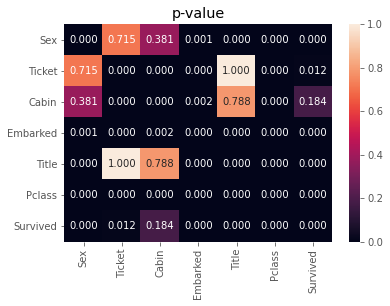

In [341]:
df_corr = pd.DataFrame(data=np.zeros(shape=(n, n)), columns=cols, index=cols)

p_value_index = 1

for row in cols:
    for col in cols:
        df_corr.loc[row, col] = get_chi_test(df_train[row], df_train[col])[p_value_index]

alpha = 0.05
cmap = sns.cm.rocket_r
sns.heatmap(df_corr, vmin=1, vmax=0, annot=True, fmt='.3f')
plt.title('p-value');

**Cramér\'s V**

In [342]:
# Reference
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

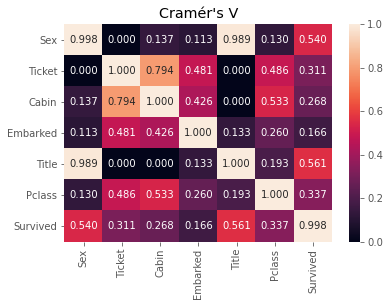

In [343]:
df_corr = pd.DataFrame(data=np.zeros(shape=(n, n)), columns=cols, index=cols)

p_value_index = 1

for row in cols:
    for col in cols:
        df_corr.loc[row, col] = cramers_v(df_train[row], df_train[col])

alpha = 0.05
cmap = sns.cm.rocket_r
sns.heatmap(df_corr, vmin=0, vmax=1, annot=True, fmt='.3f')
plt.title('Cramér\'s V');

## Summary
* Not surprisingly ('Sex', 'Embarked', 'Title', 'Pclass') are correlated with the survival.
* **'Ticket'** is correlated with the survival but 'Cabin' (p-value was 0.184) not. Tickets with same prefixes may have a similar class and survival.

# Feature Engineering